In [1]:
from pulp import *
from lpVirtualOR import LBP
from __future__ import division
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from operator import itemgetter
from collections import defaultdict
from matplotlib.backends.backend_pdf import PdfPages
import copy

%matplotlib inline

In [272]:
def sample(amount, bounds):
    #Sample Data and creates cases.
    cases = {}
    case_means = []
    total = 1
    for n,b in zip(amount,bounds):
        for j in range(total,total+n):
            cases[j] = defaultdict(int)
            cases[j]["mean"] = int(np.ceil(sum(b)/2))
            cases[j]["dur"] = np.random.random_integers(b[0],b[1])
            cases[j]["var"] = ((b[1] - b[0] + 1)**2 - 1)/12
        total += n
    return cases
    
        
class Simulation(object):
    def __init__(self,cases,order,d = 15 ,rooms = 1, L = 1, T = 12,error = 0):
        """
        oracle - tells how current surgery will last given time already finished
        order - the order toself.schedule
        d - spacing between the units of time, in minutes
        rooms - number of rooms
        L - L-step
        T - Max amount of time in day in hours
        """
        self.oracle = 0
        self.cases = copy.deepcopy(cases)
        self.order = copy.deepcopy(order)
        self.rooms = rooms
        self.L = L
        self.d = d
        self.schedule = []
        self.T_s = int(np.ceil(T*60/d))
        self.T = T
        self.error = error
        
    def set_rooms(self,rooms):
        self.rooms = rooms
        
    def set_L(self,L):
        self.L = L
        
    def get_schedule(self):
        return self.schedule[:]
    
    def run(self):
        #Initializes 
        self.schedule = [[] for _ in range(self.rooms)]
        cur_cases = [0] * self.rooms #Currently running case per room, index inside ofself.schedule not actual case number
        # Packs the first cases in each room
        for i in range(self.rooms):
            if(not self.order):
                break
            c = self.order.pop()
            data = self.cases[c]
            data["app"] = 0
            data["start"]  = 0
            self.schedule[i].append(c)
            cur_cases[i] = c   
            last_case = c
            while (self.cases[last_case]["app"] + self.cases[last_case]["mean"] < L and self.order):
                c = self.order.pop()
                data = self.cases[c]     
                data["app"] = self.cases[last_case]["app"] + self.cases[last_case]["mean"] 
                self.schedule[i].append(c)
                last_case = c #Get Last Case in rooms

        #Runs Simulation
        n = self.L
        while(self.order):
            for i in range(self.rooms):
                if(not self.schedule[i]):
                    continue
                cur = cur_cases[i]
                t =self.schedule[i].index(cur) #index of current case
                #Update current case estimates
                if(self.cases[cur]["start"] <= n):
                    cur_data = self.cases[cur]
                    #update end time
                    #cur_data["end"] = cur_data["start"] + cur_data["dur"]  
                    #update Estimate
                    cur_data["count"] += 1
                    previous = cur_data["estimate"] * (cur_data["count"] - 1)
                    dur = cur_data["dur"]
                    cur_data["estimate"] = int((previous + np.random.random_integers(dur - self.error,dur + self.error))/cur_data["count"])
                    cur_data["end"] = cur_data["start"] + cur_data["dur"]
                    if(cur_data["end"] > n):
                        continue
                    #update start time of next case
                    if(t+1 != len(self.schedule[i])):
                        next_c = self.schedule[i][t+1]
                        self.cases[next_c]["start"] = max(self.cases[next_c]["app"],cur_data["end"])   
                        if(cur_data["end"] == n-self.L):
                            cur_cases[i] = next_c

                #Calculates expected end of currentlyself.scheduled cases 
                expect = 0
                if(t+1 != len(self.schedule[i])):
                    next_c =self.schedule[i][t+1]
                    expect = self.cases[next_c]["start"]
                    for k in self.schedule[i][t+1:]:
                        expect += self.cases[k]["mean"]
                else:
                    expect = self.cases[cur]["end"]

                #Decides toself.schedule current or not
                if(expect <= n and self.order):
                    c = self.order.pop()
                    self.cases[c]["app"] = n
                    self.schedule[i].append(c)

            #update for next time step
            n += 1

        #Finish the cases after L-step is overtime
        for i in range(self.rooms):
            if(not self.schedule[i]):
                continue
            cur = cur_cases[i]
            t = self.schedule[i].index(cur) #index of current case
            #Update current case estimates
            for k in range(t,len(self.schedule[i])):
                cur = self.schedule[i][k]
                cur_data = self.cases[cur]
                #update end time
                cur_data["end"] = cur_data["start"] + cur_data["dur"]
                #update start time of next case
                if(k+1 != len(self.schedule[i])):
                    next_c = self.schedule[i][k+1]
                    self.cases[next_c]["start"] = max(self.cases[next_c]["app"],cur_data["end"])                
    
    
    def calc_cost(self):
        """
        Returns waiting_cost, idle_cost, and overtime ofself.schedule
        Outputs in minutes by multiplying with the spacing between samples
        """
        wait = 0
        idle = 0
        overtime = 0
        for r in self.schedule:
            if(r):
                for i in range(len(r)-1):
                    diff = self.cases[r[i+1]]["app"] - self.cases[r[i]]["end"] 
                    wait += max(-diff,0)
                    idle += max(diff,0)
                last = self.cases[r[-1]]
                overtime += max(0,last["end"] - self.T_s) 
        wait *= self.d
        idle *= self.d
        overtime *= self.d
        return wait,idle, overtime

In [341]:
def create_order(cases,heauristic = "largest mean"):
    if heauristic == "largest mean":
        return [j[0] for j in sorted(cases.items(),key= lambda x: (x[1]["mean"],x[0]))] 
    elif heauristic == "smallest mean":
        return [ j[0] for j in sorted(cases.items(),key= lambda x: (x[1]["mean"],x[0]))] [::-1]
    elif heauristic == "random":
        return np.random.permutation([j[0] for j in cases.items()]).tolist()
    elif heauristic == "largest var":
        return [j[0] for j in sorted(cases.items(),key= lambda x: (x[1]["var"],x[0]))] 
    elif heauristic == "smallest var":
        return [ j[0] for j in sorted(cases.items(),key= lambda x: (x[1]["var"],x[0]))] [::-1]

In [274]:
#Initial Setup
T = 12 #Size of schedule in hours
rooms_N = 3
L = 3

cases = sample([10,7,3],bounds = [(1,5),(3,10),(7,13)])
sorted_list = create_order(cases,"largest var")
sim = Simulation(cases,sorted_list,d = 15,L=L,rooms=rooms_N, T = T,error =0 )
sim.run()
wait, idle, over = sim.calc_cost()
print "Waiting = {0} units, Idle = {1} units, over = {2}".format(wait,idle,over)

Waiting = 75 units, Idle = 75 units, over = 0


48


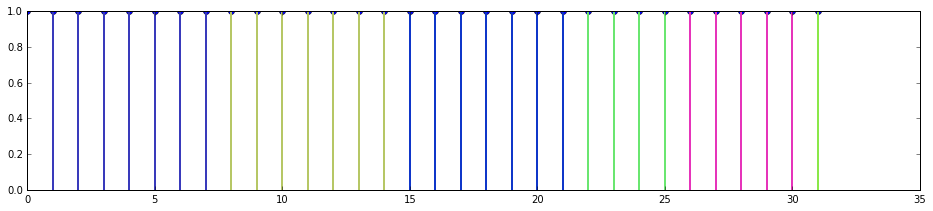

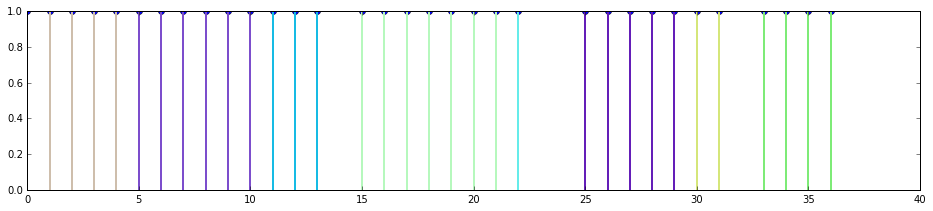

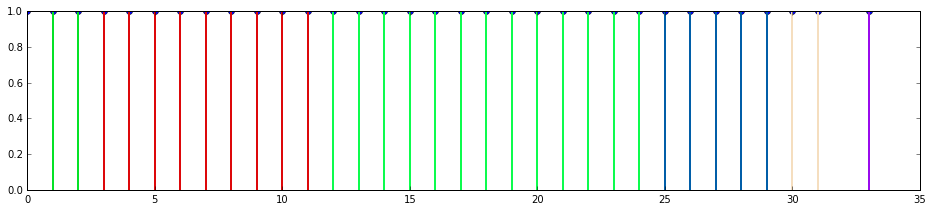

In [277]:
#Plotting Rooms
print sim.T_s
rooms = sim.schedule
for room in rooms:
    width, height = plt.figaspect(0.2)
    plt.figure(figsize=(width,height))
    for k in room:
        l = range(sim.cases[k]["start"],sim.cases[k]["end"])
        markerline, stemlines, baseline = plt.stem(l, np.ones(len(l)))
        c = color = np.random.rand(3,1)
        plt.setp(stemlines, linewidth=2, color=c)     # set stems to random colors
        plt.setp(markerline, 'markerfacecolor', 'b')

In [342]:
T = 12 #Size of schedule in hours
L_range = np.r_[2:300//15:2]
N = [100,70,30] #Number of cases to schedule per types
Total = np.sum(N) #Total number of Cases
rooms_N = 10
error = 1

runs = 100
costs_L = np.zeros((len(L_range),3))
costs_S = np.zeros((len(L_range),3))
costs_R = np.zeros((len(L_range),3))
costs_Lv = np.zeros((len(L_range),3))
costs_Sv = np.zeros((len(L_range),3))

for i in range(len(L_range)):
    L = L_range[i]
    #Large
    for _ in range(runs):
        cases = sample(N,bounds = [(1,5),(3,10),(7,13)])
        
        sorted_list = create_order(cases,"largest mean")
        sim = Simulation(cases,sorted_list,d = 15,L=L,rooms=rooms_N, T = T )
        sim.run()
        costs_L[i] += sim.calc_cost()
        
        # Small
        sorted_list = create_order(cases,"smallest mean")
        sim = Simulation(cases,sorted_list,d = 15,L=L,rooms=rooms_N, T = T )
        sim.run()
        costs_S[i] += sim.calc_cost()
        
        # Random
        sorted_list = create_order(cases,"random")
        sim = Simulation(cases,sorted_list,d = 15,L=L,rooms=rooms_N, T = T )
        sim.run()
        costs_R[i] += sim.calc_cost()

        #Largest Var
        sorted_list = create_order(cases,"largest var")
        sim = Simulation(cases,sorted_list,d = 15,L=L,rooms=rooms_N, T = T )
        sim.run()
        costs_Lv[i] += sim.calc_cost()
        
        # Smallest Var
        sorted_list = create_order(cases,"smallest var")
        sim = Simulation(cases,sorted_list,d = 15,L=L,rooms=rooms_N, T = T )
        sim.run()
        costs_Sv[i] += sim.calc_cost()
        
costs_L /= runs * Total
costs_S /= runs * Total
costs_R /= runs * Total
costs_Lv /= runs * Total
costs_Sv /= runs * Total


In [343]:
#Make PDF
pp = PdfPages("results.pdf")

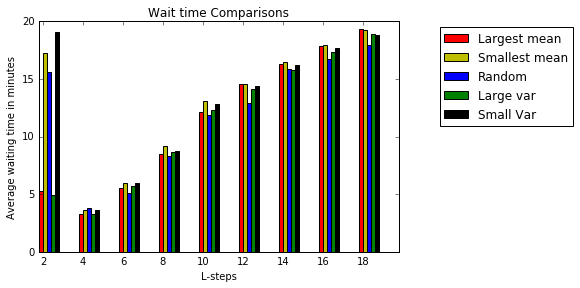

In [344]:
#Waiting time
width, height = plt.figaspect(0.4)
fig, ax = plt.subplots()
fig.set_figwidth(width)
fig.set_figheight(height)


ind = np.arange(len(L_range))  # the x locations for the groups
width = 0.1       # the width of the bars

large_m = ax.bar(ind, costs_L[:,0], width, color='r')
small_m = ax.bar(ind + width, costs_S[:,0], width, color='y')
random = ax.bar(ind + 2*width, costs_R[:,0], width, color='b')
large_v = ax.bar(ind + 3*width, costs_Lv[:,0], width, color='g')
small_v = ax.bar(ind + 4*width, costs_Sv[:,0], width, color='k')

# add some text for labels, title and axes ticks
ax.set_xlabel('L-steps')
ax.set_ylabel('Average waiting time in minutes')
ax.set_title('Wait time Comparisons')
ax.set_xticks(ind + width)
ax.set_xticklabels(L_range)
ax.set_position([0.1,0.1,0.5,0.8])

ax.legend((large_m[0], small_m[0], random[0],large_v[0], small_v[0]), ('Largest mean', 'Smallest mean',"Random", "Large var","Small Var"),bbox_to_anchor=(1.5, 1))

pp.savefig()

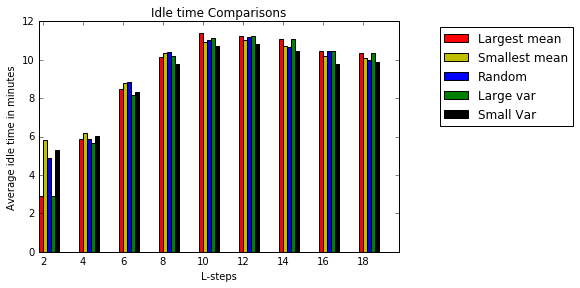

In [345]:
#Idle time
width, height = plt.figaspect(0.4)
fig, ax = plt.subplots()
fig.set_figwidth(width)
fig.set_figheight(height)

ind = np.arange(len(L_range))  # the x locations for the groups
width = 0.1       # the width of the bars

large_m = ax.bar(ind, costs_L[:,1], width, color='r')
small_m = ax.bar(ind + width, costs_S[:,1], width, color='y')
random = ax.bar(ind + 2*width, costs_R[:,1], width, color='b')
large_v = ax.bar(ind + 3*width, costs_Lv[:,1], width, color='g')
small_v = ax.bar(ind + 4*width, costs_Sv[:,1], width, color='k')

# add some text for labels, title and axes ticks
ax.set_xlabel('L-steps')
ax.set_ylabel('Average idle time in minutes')
ax.set_title('Idle time Comparisons')
ax.set_xticks(ind + width)
ax.set_xticklabels(L_range)
ax.set_position([0.1,0.1,0.5,0.8])

ax.legend((large_m[0], small_m[0], random[0],large_v[0], small_v[0]), ('Largest mean', 'Smallest mean',"Random", "Large var","Small Var"),bbox_to_anchor=(1.5, 1))

pp.savefig()

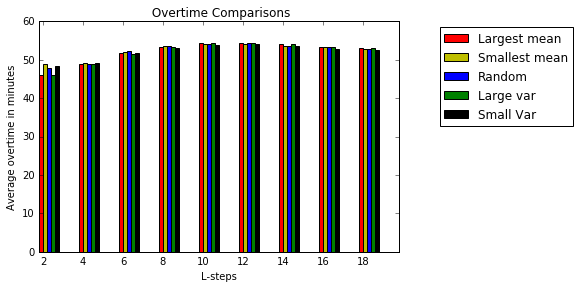

In [346]:
#Overtime time
width, height = plt.figaspect(0.4)
fig, ax = plt.subplots()
fig.set_figwidth(width)
fig.set_figheight(height)

ind = np.arange(len(L_range))  # the x locations for the groups
width = 0.1       # the width of the bars

large_m = ax.bar(ind, costs_L[:,2], width, color='r')
small_m = ax.bar(ind + width, costs_S[:,2], width, color='y')
random = ax.bar(ind + 2*width, costs_R[:,2], width, color='b')
large_v = ax.bar(ind + 3*width, costs_Lv[:,2], width, color='g')
small_v = ax.bar(ind + 4*width, costs_Sv[:,2], width, color='k')

# add some text for labels, title and axes ticks
ax.set_xlabel('L-steps')
ax.set_ylabel('Average overtime in minutes')
ax.set_title(' Overtime Comparisons')
ax.set_xticks(ind + width)
ax.set_xticklabels(L_range)
ax.set_position([0.1,0.1,0.5,0.8])

ax.legend((large_m[0], small_m[0], random[0],large_v[0], small_v[0]), ('Largest mean', 'Smallest mean',"Random", "Large var","Small Var"),bbox_to_anchor=(1.5, 1))

pp.savefig()

In [347]:
pp.close()